# `litebird_sim` example notebook 

**Attention! This notebook can work only after having downloaded the Litebird IMO information.**

You will have to ask the permission to access the private repository https://github.com/litebird/litebird_imo and then install it following [the documentation](https://litebird-sim.readthedocs.io/en/master/tutorial.html#interacting-with-the-imo).

To run this notebook, you should have already installed `litebird_sim` using the command

```
pip install .
```

## Set up the environment

We start by importing a few libraries that will be useful in this notebook.

In [1]:
import litebird_sim as lbs
import numpy as np
import matplotlib.pylab as plt
import healpy as hp
import astropy
from astropy.time import Time

%matplotlib inline

TOAST INFO: mpi4py not found- using serial operations only


# Parameters of the simulation

We will simulate a pair of 140 GHz MFT detectors. Their definition will be taken from the LiteBIRD Instrument MOdel (IMO) version 1.3 (**new!**).

In [2]:
telescope = "LFT"
channel = "L4-140"
detlist = ["000_001_017_QB_140_T", "000_001_017_QB_140_B"]

start_time = astropy.time.Time("2025-01-01T00:00:00")
mission_time_days = 365

imo_version = "v1.3"

# Resolution of the output maps
nside = 64

In [3]:
# This is the folder where the final report with the results of the simulation will be saved
base_path = ".test"

# This loads the full IMO (not only the version specified by `imo_version`!)
imo = lbs.Imo()

# initializing the simulation
sim = lbs.Simulation(
    base_path=base_path,
    # mpi_comm=comm,  <--- needed if parallelizing
    start_time=start_time,
    duration_s=mission_time_days * 24 * 3600.0,
)

# Load the definition of the instrument (MFT)
inst_info = lbs.InstrumentInfo.from_imo(
    imo, f"/releases/{imo_version}/satellite/{telescope}/instrument_info"
)

In [4]:
# filling dets with info and detquats with quaternions of the detectors in detlist
dets = []
for n_det in detlist:
    det = lbs.DetectorInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/{n_det}/detector_info",
        imo=imo,
    )

    # we overwrite the nominal sampling rate read from IMO with a smaller one, so that
    # we produce 1 yr tod without taking too much memory
    det.sampling_rate_hz = 1

    dets.append(det)

The following command will take some time: it needs to compute the ephemerides of the Earth with respect to the Ecliptic reference frame and derive the orientation of the MFT instrument as a function of time for the whole duration of the simulation. This step will be needed later, when we will obtain the pointings for the detectors involved in the simulation.

In [5]:
# Generate the quaternions describing how the instrument moves in the Ecliptic reference frame
sim.generate_spin2ecl_quaternions(
    imo_url=f"/releases/{imo_version}/satellite/scanning_parameters/"
)

#### Making TOD and maps of CMB+foreground

Let's now create a set of «observations». This concept was mutuated by [TOAST](https://github.com/hpc4cmb/toast), and it represents a chunk of data acquired while the instrument was in almost stable conditions (i.e., stationary noise, no thermal drifts…). For the sake of simplicity, we create just *one* observation, but of course in realistic simulations you will have several observations spread among the available MPI processes.

In [6]:
# creating one observation
sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # blocks different from one if parallelizing
)

The call above allocated the memory necessary to hold the TOD samples. However, to produce a map, we need pointing information, i.e., the information about the direction and orientation of each receiver as a function of time.

So, here comes the part where we need to simulate the pointings. Much of the work has already been done, as the ephemerides were already computed in the call to `sim.generate_spin2ecl_quaternions` (see above), but this step is going to take its time too, because we are now deriving the pointings for **each** detector and store them in the list `pointings`.

In [7]:
pointings = lbs.get_pointings_for_observations(
    sim.observations,
    spin2ecliptic_quats=sim.spin2ecliptic_quats,
    bore2spin_quat=inst_info.bore2spin_quat,
    hwp=lbs.IdealHWP(
        inst_info.hwp_rpm * 2 * np.pi / 60,
    ),  # applies hwp rotation angle to the polarization angle
    store_pointings_in_obs=True,  # if True, stores colatitude and longitude in
    # sim.observations[:].pointings, and the polarization angle in
    # sim.observations[:].psi
)

`pointings` is a 3-rank matrix with a $N_{\rm{det}} \times N_{\rm{sample}} \times 3$ array, with the last rank containing the colatitude, longitude, and polarization angles (in radians). There are as many `pointings` arrays as the number of observations in `sim.observations`.

In [8]:
pointings[0].shape

(2, 31536000, 3)

Now we know where the detectors are looking at. Let's produce a synthetic image of the sky at the frequencies sampled by the two detectors we're simulating; for this, we need the information about the frequency channel we are simulating (140 GHz), so we retrieve them from the IMO again:

In [9]:
# loading channel info
ch_info = []
ch_info.append(
    lbs.FreqChannelInfo.from_imo(
        url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
        imo=imo,
    )
)

The LiteBIRD Simulation Framework provides MBS, which is a wrapper to PySM; we use it to produce a map of the sky including synchrotron, free-free, and dust, and we smooth the map according to the FWHM specified in the IMO. (Note that we do not need to pass this information explicitly, as MBS is able to extract it from `ch_info`.)

In [10]:
# let's make an input CMB+foreground map

# this sets the parameters for the generation of the map
Mbsparams = lbs.MbsParameters(
    make_cmb=True,
    make_fg=True,
    seed_cmb=1,
    fg_models=[
        "pysm_synch_0",
        "pysm_freefree_1",
        "pysm_dust_0",
    ],  # set the FG models you want
    gaussian_smooth=True,  # if True, smooths the input map by the beam of the channel
    bandpass_int=False,  # if True, integrates over the top-hat bandpass of the channel
    nside=nside,
    units="K_CMB",
    maps_in_ecliptic=False,
)

mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=ch_info
    # detector_list = dets      #use detector_list instead of channel_list if your sim has detectors
    # from different channels. It would produce a map for each detector in dets
)
maps = mbs.run_all()[0]  # generates the map as a dictionary

[2022-09-20 15:54:29,845 INFO MPI#0000] generating and saving cmb simulations
[2022-09-20 15:54:29,889 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-09-20 15:54:29,890 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-09-20 15:54:29,946 INFO MPI#0000] Access data from /Users/luca/Documents/Universita/litebird/simteam/codes/litebird_sim/notebooks/.test/cmb/0000/cmb_0000_date_220920.fits
[2022-09-20 15:54:29,960 INFO MPI#0000] NSIDE = 64
[2022-09-20 15:54:29,960 INFO MPI#0000] ORDERING = RING in fits file
[2022-09-20 15:54:29,961 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-09-20 15:54:30,010 INFO MPI#0000] Sigma is 10.064463 arcmin (0.002928 rad) 
[2022-09-20 15:54:30,011 INFO MPI#0000] -> fwhm is 23.700000 arcmin
[2022-09-20 15:54:30,012 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-09-20 15:54:30,013 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-09-20 15:54:30,019 INFO MPI#0000] generating and saving fg simulations
[2022-09-20 15:54:30,021 INFO MPI#0000] Re

***************** D
***************** D
***************** D


[2022-09-20 15:54:30,234 INFO MPI#0000] Retrieve data for pysm_2/synch_q_new.fits (if not cached already)
[2022-09-20 15:54:30,240 INFO MPI#0000] NSIDE = 512
[2022-09-20 15:54:30,240 INFO MPI#0000] ORDERING = RING in fits file
[2022-09-20 15:54:30,241 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-09-20 15:54:30,349 INFO MPI#0000] Retrieve data for pysm_2/synch_u_new.fits (if not cached already)
[2022-09-20 15:54:30,354 INFO MPI#0000] NSIDE = 512
[2022-09-20 15:54:30,355 INFO MPI#0000] ORDERING = RING in fits file
[2022-09-20 15:54:30,356 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-09-20 15:54:32,570 INFO MPI#0000] Sigma is 10.064463 arcmin (0.002928 rad) 
[2022-09-20 15:54:32,570 INFO MPI#0000] -> fwhm is 23.700000 arcmin
[2022-09-20 15:54:32,571 INFO MPI#0000] Sigma is 0.000000 arcmin (0.000000 rad) 
[2022-09-20 15:54:32,572 INFO MPI#0000] -> fwhm is 0.000000 arcmin
[2022-09-20 15:54:32,579 INFO MPI#0000] Retrieve data for pysm_2/ff_t_new.fits (if not cached already)
[2022-09-20 15:54:32,583 

It's time to simulate the observation of the map by the two receivers. This is done by the function `scan_map_in_observations`:

In [11]:
lbs.scan_map_in_observations(
    sim.observations,
    maps=maps,
    input_map_in_galactic=True,
)

be careful, `lbs.scan_map_in_observations` adds signal to the observation.tod

The TOD has shape $N_{\rm{det}}$ x $N_{\rm{sample}}$

In [12]:
sim.observations[0].tod.shape

(2, 31536000)

# Map-making

Now that we have a TOD, let's bin it into a map! The LiteBIRD Simulation Framework provides two map-makers:

1. A simple binner, which is the first we'll use;

2. A wrapper to the T map-maker, provided through a binding to the TOAST2 library.

Let's start from the binner.

In [13]:
m_cmb_fg, m_cmb_fg_cov = lbs.make_bin_map(
    obs=sim.observations,   # pointing stored in the observations
    nside=nside,  # one can set also a different resolution than the input map
    do_covariance=True,  # this generates the covariance maps
    output_map_in_galactic=True,
)

The noise covariance matrix for each pixel is $\sigma^2 \left(A^T A\right)^{-1}$, where $A$ is the pointing matrix, with dimensions $N_{\rm{samples}} × \left(3 × N_{\rm{pixels}} \right)$ and $\sigma$ is in $\mu$K

$\left(A^T A\right)$ represents how many times the pixel has been visited, so $\sigma^2 \left(A^T A\right)^{-1}$ represents the noise of the pixel weighted by the times it has been observed

In [14]:
# the cov map has shape npix×3×3
m_cmb_fg_cov.shape

(49152, 3, 3)

Now that we have produced the binned map, we can compare it with the input map produced by PySM. Here is the map we have just produced:

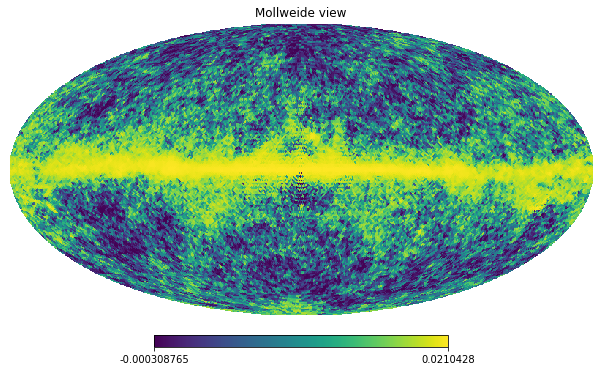

In [15]:
hp.mollview(m_cmb_fg[0], norm="hist")

And here is the original map created by MBS:

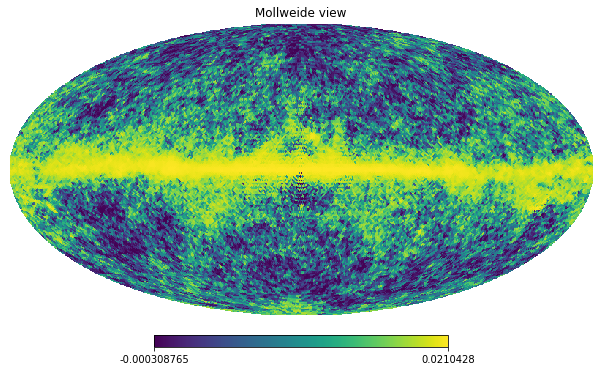

In [16]:
hp.mollview(maps["L4-140"][0], norm="hist")

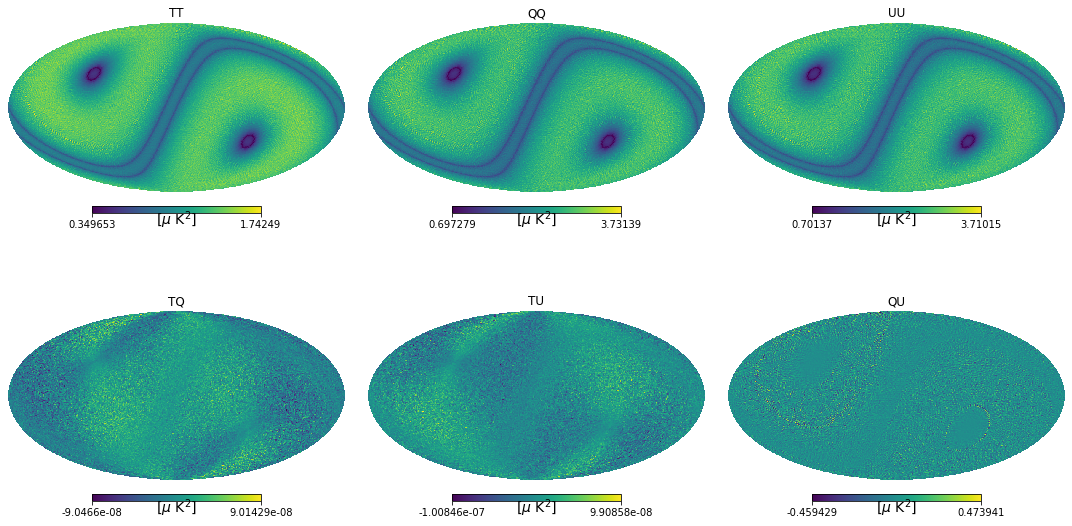

In [17]:
plt.figure(figsize=(15, 8))
hp.mollview(m_cmb_fg_cov[:, 0, 0], sub=231, title="TT", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 1, 1], sub=232, title="QQ", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 2, 2], sub=233, title="UU", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 0, 1], sub=234, title="TQ", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 0, 2], sub=235, title="TU", unit=r"[$\mu$ K$^2$]")
hp.mollview(m_cmb_fg_cov[:, 1, 2], sub=236, title="QU", unit=r"[$\mu$ K$^2$]")

The following map shows the difference between the input map and the output map:

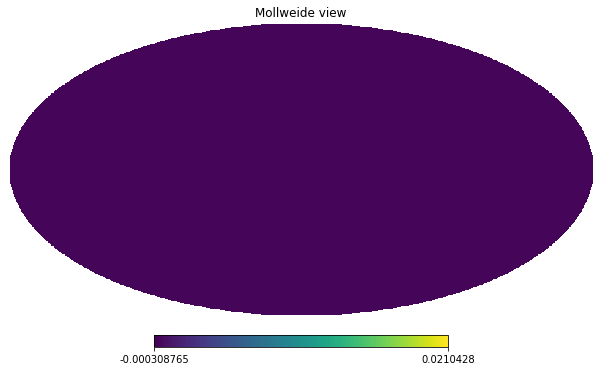

In [18]:
hp.mollview(
    maps["L4-140"][0] - m_cmb_fg[0], min=np.min(m_cmb_fg[0]), max=np.max(m_cmb_fg[0])
)

## Making TOD and maps of white+1/f noise

Let's add white + 1/f noise to the CMB+FG TOD

In [19]:
lbs.add_noise_to_observations(
    obs=sim.observations,
    noise_type="one_over_f",
    scale=1,  # it can be used to introduce measurement unit conversions when
    # appropriate. Default units: [K].
    # random=random      #The parameter `random`, if specified,
    # must be a random number generator that
    # implements the ``normal`` method
)

Let's compare a noise map done with the `litebird_sim` binning mapmaker and with the TOAST binning mapmaker. First the destriper:

In [20]:
param_noise_toast = lbs.DestriperParameters(
    nside=nside,
    nnz=3,  # Compute I, Q, and U
    baseline_length_s=100,  # Since each sample lasts 1s, we are using a baseline of length 100 s
    return_hit_map=True,
    return_binned_map=True,
    return_destriped_map=True,
    coordinate_system=lbs.coordinates.CoordinateSystem.Galactic,
    iter_max=10,
)

In [21]:
result = lbs.destripe(sim=sim, params=param_noise_toast, pointings=pointings)

[2022-09-20 15:55:24,592 WARNING MPI#0000] converting pointings for 000_001_017_QB_140_T from float32 to float64
[2022-09-20 15:55:24,991 WARNING MPI#0000] converting TODs for 000_001_017_QB_140_T from float32 to float64
[2022-09-20 15:55:36,839 WARNING MPI#0000] converting pointings for 000_001_017_QB_140_B from float32 to float64
[2022-09-20 15:55:37,290 WARNING MPI#0000] converting TODs for 000_001_017_QB_140_B from float32 to float64


TOAST INFO: Flag gaps:  0.05 seconds (1 calls)
TOAST INFO: Get detector weights:  0.00 seconds (1 calls)
TOAST INFO: Accumulate N_pp'^1:  11.47 seconds (1 calls)
TOAST INFO: All reduce N_pp'^1:  0.00 seconds (1 calls)
TOAST INFO: Wrote hits to .test/lbs_hits.fits
TOAST INFO: Write hits:  0.08 seconds (1 calls)
TOAST INFO: Wrote inverse white noise covariance to .test/lbs_invnpp.fits
TOAST INFO: Write N_pp'^1:  0.06 seconds (1 calls)
TOAST INFO: Compute reciprocal condition numbers:  0.03 seconds (1 calls)
TOAST INFO: Wrote reciprocal condition numbers to .test/lbs_rcond.fits
TOAST INFO: Write rcond:  0.01 seconds (1 calls)
TOAST INFO: Invert N_pp'^1:  0.05 seconds (1 calls)
TOAST INFO: Wrote white noise covariance to .test/lbs_npp.fits
TOAST INFO: Write N_pp':  0.03 seconds (1 calls)
TOAST INFO:   Build noise-weighted map:  0.00 seconds (0 calls)
TOAST INFO:   Apply noise covariance:  0.00 seconds (0 calls)
TOAST INFO:   Write map to .test/lbs_binned.fits:  0.00 seconds (0 calls)
TOAST

[2022-09-20 16:00:56,115 INFO MPI#0000] NSIDE = 64
[2022-09-20 16:00:56,128 INFO MPI#0000] ORDERING = NESTED in fits file
[2022-09-20 16:00:56,130 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-09-20 16:00:56,143 INFO MPI#0000] Ordering converted to RING
[2022-09-20 16:00:56,149 INFO MPI#0000] NSIDE = 64
[2022-09-20 16:00:56,150 INFO MPI#0000] ORDERING = NESTED in fits file
[2022-09-20 16:00:56,151 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-09-20 16:00:56,158 INFO MPI#0000] Ordering converted to RING
[2022-09-20 16:00:56,160 INFO MPI#0000] Ordering converted to RING
[2022-09-20 16:00:56,165 INFO MPI#0000] Ordering converted to RING
[2022-09-20 16:00:56,186 INFO MPI#0000] NSIDE = 64
[2022-09-20 16:00:56,188 INFO MPI#0000] ORDERING = NESTED in fits file
[2022-09-20 16:00:56,193 INFO MPI#0000] INDXSCHM = IMPLICIT
[2022-09-20 16:00:56,201 INFO MPI#0000] Ordering converted to RING
[2022-09-20 16:00:56,204 INFO MPI#0000] Ordering converted to RING
[2022-09-20 16:00:56,208 INFO MPI#0000] Ordering con

We invoke the binner on the TOD containing 1/f and white noise:

In [ ]:
m_noise_bin = lbs.make_bin_map(
    obs=sim.observations,
    nside=nside,  # one can set also a different resolution than the input map
    do_covariance=False,
    output_map_in_galactic=True,
)

In [ ]:
m_noise_toast_bin = result.binned_map
m_noise_destr = result.destriped_map

As a few pixels might have been left out of the map because of the scanning strategy, we set them to `NaN`:

In [ ]:
mask = (result.hit_map == 0) | (result.binned_map == 0.0)
m_noise_toast_bin[mask] = np.NaN
m_noise_destr[mask] = np.NaN
m_noise_bin[mask] = np.NaN

Let's give a quick look at the difference between the binned map of `make_bin_map` and TOAST. They agree pretty well

In [ ]:
hp.mollview(1e6*(m_noise_bin - m_noise_toast_bin)[0],min=-0.01,max=0.01,unit=r'$\mu$ K')
hp.mollview(1e6*(m_noise_bin - m_noise_toast_bin)[1],min=-0.01,max=0.01,unit=r'$\mu$ K')

now the difference between the destriped and the binned map

In [ ]:
hp.mollview(1e6*(m_noise_destr[0] - m_noise_bin[0]), title="I map",min=-1,max=1,unit=r'$\mu$ K')
hp.mollview(1e6*(m_noise_destr[1] - m_noise_bin[1]), title="Q map",min=-1,max=1,unit=r'$\mu$ K')

computing the spectra

In [ ]:
cl_map_original = hp.anafast(maps["L4-140"])
cl_map_noise_bin = hp.anafast(m_noise_bin)
cl_map_noise_toast_bin = hp.anafast(m_noise_toast_bin)
cl_map_noise_destr = hp.anafast(m_noise_destr)

In [ ]:
plt.figure(figsize=(14,8))
ell = np.arange(cl_map_noise_bin[0].size)
plt.loglog(ell[2:], cl_map_original[0, 2:] * 1e12, lw=4, label="TT, Original")
plt.loglog(ell[2:], cl_map_noise_bin[0, 2:] * 1e12, label="TT, binning",lw=3)
plt.loglog(
    ell[2:], cl_map_noise_toast_bin[0, 2:] * 1e12, label="TT, TOAST binning", ls=":",lw=3
)
plt.loglog(ell[2:], cl_map_noise_destr[0, 2:] * 1e12, label="TT, destriper", ls="--",lw=3)
plt.legend()
plt.ylabel(r"$C_{\ell}$ [$\mu$K$^2$]",fontsize=18)
plt.xlabel(r"$\ell$",fontsize=18)

In [ ]:
plt.figure(figsize=(14,8))
plt.loglog(ell[2:], cl_map_original[1, 2:] * 1e12, lw=4, label="EE, Original")
plt.loglog(ell[2:], cl_map_noise_bin[1, 2:] * 1e12, label="EE, binning",lw=3)
plt.loglog(
    ell[2:], cl_map_noise_toast_bin[1, 2:] * 1e12, label="EE, TOAST binning", ls=":",lw=3
)
plt.loglog(ell[2:], cl_map_noise_destr[1, 2:] * 1e12, label="EE, destriper", ls="--",lw=3)
plt.loglog(ell[2:], cl_map_original[2, 2:] * 1e12, lw=4, label="BB, Original")
plt.loglog(ell[2:], cl_map_noise_bin[2, 2:] * 1e12, label="BB, binning",lw=3)
plt.loglog(
    ell[2:], cl_map_noise_toast_bin[2, 2:] * 1e12, label="BB, TOAST binning", ls=":",lw=3
)
plt.loglog(ell[2:], cl_map_noise_destr[2, 2:] * 1e12, label="BB, destriper", ls="--",lw=3)
plt.legend()
plt.ylabel(r"$C_{\ell}$ [$\mu$K$^2$]",fontsize=18)
plt.xlabel(r"$\ell$",fontsize=18)

#### Making dipole TOD

In [ ]:
(obs_dipole,) = sim.create_observations(
    detectors=dets,
    n_blocks_det=1,
    n_blocks_time=1,  # size,
)

If `sim.create_observations` is executed again, `sim.observations` is overwritten. In fact the TOD is null again:

In [ ]:
for i_ob in range(len(sim.observations)):
    print(sim.observations[i_ob].tod)

In [ ]:
orbit = lbs.SpacecraftOrbit(sim.start_time)
pos_vel = lbs.spacecraft_pos_and_vel(orbit=orbit, obs=sim.observations, delta_time_s=86400.0)

In [ ]:
lbs.add_dipole_to_observations(
    obs=sim.observations,
    pos_and_vel=pos_vel,
    pointings=pointings,
    dipole_type=lbs.DipoleType.TOTAL_FROM_LIN_T,
)

In [ ]:
plt.plot(obs_dipole.tod[0, :100000])

In [ ]:
m_dipole = lbs.make_bin_map(
    obs=sim.observations,
    nside=nside,  # one can set also a different resolution than the input map
    pointings=pointings,
    do_covariance=False,
    output_map_in_galactic=True,
)

In [ ]:
hp.mollview(m_dipole[0])

let's fit the dipole map to see if the dipole orientation agrees with Planck one (see arxiv:1807.06207)

colatitude: 0.7286226027948965,
longitude:  4.6080357444

In [ ]:
hp.fit_dipole(m_dipole[0])

In [ ]:
hp.vec2ang(np.array([-0.00023298, -0.00222625, 0.0025082]))

the agreement is pretty good (we have also orbital dipole)